# Imports

In [1]:
from copy import deepcopy
import fiona
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import rasterio.mask
from rasterio.crs import CRS
from rasterio.warp import Affine, transform_geom, calculate_default_transform, Resampling
import shapely 
from shapely.ops import unary_union
from shapely import affinity
from shapely import Polygon, MultiPolygon, box 
#from skimage.measure import block_reduce
from typing import List

In [2]:
from utilities.area import EARTH_RADIUS, show_stats, get_scales
from utilities.geojson import filter_features, filter_features_by_list, get_polygons, convert_dict_to_shapely
from utilities.plotting import get_projection_xticks, get_projection_yticks

## Boundary data
https://www.geoboundaries.org/countryDownloads.html 

https://data.metabolismofcities.org/dashboards/johannesburg/hub/harvesting/852/

In [3]:
data_dir = '../../datasets/geospatial/'

United Kingdom

In [4]:
london_boroughs = [
    'City of London', 'Westminster', 'Kensington and Chelsea', 'Hammersmith and Fulham', 'Wandsworth', 'Lambeth',
    'Southwark', 'Tower Hamlets', 'Hackney', 'Islington', 'Camden', 'Brent', 'Ealing', 'Hounslow', 'Richmond upon Thames',
    'Kingston upon Thames', 'Merton', 'Sutton', 'Croydon', 'Bromley', 'Lewisham', 'Greenwich', 'Bexley', 'Havering',
    'Barking and Dagenham', 'Redbridge', 'Newham', 'Waltham Forest','Haringey', 'Enfield', 'Barnet', 'Harrow',
    'Hillingdon'
]
inner_city_boroughs = [
    'Islington', 'Camden', 'Westminster', 'Southwark', 'Tower Hamlets', 'Hackney', 'Lambeth'
]

In [5]:
geojson_filepath = os.path.join(data_dir, 'geoBoundaries-GBR-ADM2-all/geoBoundaries-GBR-ADM2.geojson')
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    
london_borough_features = filter_features_by_list(shape_data, 'shapeName', london_boroughs)
london_borough_polygons = get_polygons(london_borough_features, keep_top=1)
inner_city_borough_features = filter_features_by_list(shape_data, 'shapeName', inner_city_boroughs)
inner_city_borough_polygons = get_polygons(inner_city_borough_features, keep_top=1)

South Africa

In [ ]:
data_path = os.path.join(data_dir, '2018_Regions_CoJ/2018_Regions.shp')
city_of_joburg_data = fiona.open(data_path, "r")
polygons = get_polygons(city_of_joburg_data, identifier='REGION_NAM')
city_of_joburg_projected = transform_geom(
    city_of_joburg_data.crs,
    rasterio.crs.CRS.from_epsg(4326),
    polygons.values()
)
city_of_joburg_polygons = dict(
    (name, Polygon(geom['coordinates'][0])) for name, geom in zip(polygons.keys(), city_of_joburg_projected)
)

France

In [ ]:
# for feat in shape_data['features']:
#     print(feat['properties']['shapeName'], end=', ')

In [ ]:
paris_departments = [
    'Paris', 'Val-de-Marne', 'Hauts-de-Seine', 'Seine-Saint-Denis'
]

In [ ]:
geojson_filepath = os.path.join(data_dir, 'geoBoundaries-FRA-ADM2-all/geoBoundaries-FRA-ADM2.geojson')
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
paris_department_features = filter_features_by_list(shape_data, 'shapeName', paris_departments)
paris_department_polygons = get_polygons(paris_department_features, keep_top=1)
    
paris_feature = filter_features(shape_data, 'shapeName', 'Paris')
paris_polgyon = get_polygons(paris_feature, keep_top=1)['Paris']

Netherlands

In [ ]:
geojson_filepath = os.path.join(data_dir, 'geoBoundaries-NLD-ADM1-all/geoBoundaries-NLD-ADM1.geojson')
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    
holland_features = filter_features_by_list(shape_data, 'shapeName', ['Noord-Holland', 'Zuid-Holland'])
holland_polygons = get_polygons(holland_features, keep_top=1)

Philipines

In [ ]:
# for feat in shape_data['features']:
#     print(feat['properties']['shapeName'], end='; ')

In [ ]:
manila_divisons = [
    'NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'
]

In [ ]:
geojson_filepath = os.path.join(data_dir, 'geoBoundaries-PHL-ADM2-all/geoBoundaries-PHL-ADM2.geojson')
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
manila_divison_features = filter_features_by_list(shape_data, 'shapeName', manila_divisons)
print(len(manila_divison_features))
manila_divison_polygons = get_polygons(manila_divison_features, keep_top=1)

New York, USA

- change second 'Richmond' to 'Richmond, NY'
- change second 'Kings' to 'Kings, NY'

In [ ]:
# for feat in shape_data['features']:
#     print(feat['properties']['shapeName'], end='; ')

In [6]:
new_york_counties = ['New York', 'Bronx', 'Kings, NY', 'Queens', 'Richmond, NY']

In [7]:
geojson_filepath = os.path.join(data_dir, 'geoBoundaries-USA-ADM2-all/geoBoundaries-USA-ADM2.geojson')
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
new_york_features = filter_features_by_list(shape_data, 'shapeName', new_york_counties)
new_york_polygons = get_polygons(new_york_features)

Israel

In [ ]:
geojson_filepath = 'data/geoBoundaries-ISR-ADM2-all/geoBoundaries-ISR-ADM2.geojson'
geojson_filepath = os.path.join(data_dir, 'geoBoundaries-ISR-ADM2-all/geoBoundaries-ISR-ADM2.geojson')
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
israel_polygons = get_polygons(shape_data['features'], keep_top=1)

### Plotting

In [8]:
def plot_polygon(axes, shape, **kwargs):
    if isinstance(shape, Polygon):
        polygon = shape
        xs, ys = polygon.exterior.coords.xy
        axes.plot(xs, ys, 'k-', **kwargs)
    elif isinstance(shape, MultiPolygon):
        for polygon in shape.geoms:
            xs, ys = polygon.exterior.coords.xy
            axes.plot(xs, ys, 'k-', **kwargs)
    else:
        print(f'Shape at idx {idx} is of type {type(shape)} is not supported')
    return axes

def plot_polygons(axes, polygons: List):
    for idx, shape in enumerate(polygons):
        plot_polygon(axes, shape)
    return axes

In [9]:
admin_polygons = london_borough_polygons
region_name = 'London'

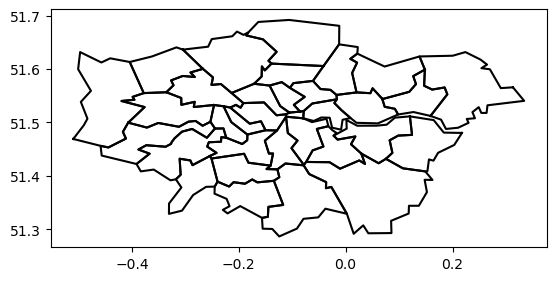

In [10]:
fig, ax = plt.subplots()
plot_polygons(ax, admin_polygons.values())
ax.set_aspect('equal')
ax.plot();

In [11]:
region_polygon = unary_union(list(admin_polygons.values()))

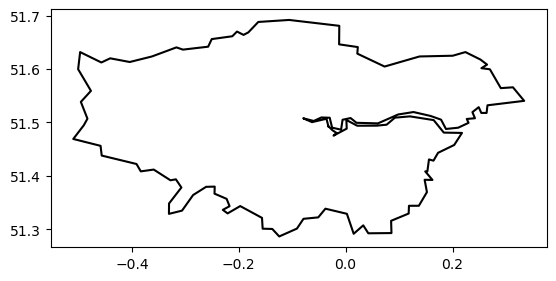

In [12]:
fig, ax = plt.subplots()
plot_polygon(ax, region_polygon)
ax.set_aspect('equal')

reproject onto a transverse mercator to remove distortion (longitude lines stretched apart)

In [13]:
long_min, lat_min, long_max, lat_max = region_polygon.bounds
long_avg = (long_min + long_max) / 2
long_avg

-0.087862460334735

In [14]:
dst_crs = {
    'proj': 'tmerc',
    'lat_0': 0,
    'lon_0': long_avg,
    'k': 1/1000, # convert to km
    'x_0': 0,
    'y_0': 0,
    'ellps': 'WGS84',
    'units': 'm',
    'no_defs': True
}
src_crs = CRS.from_epsg(4326)

In [15]:
polygons_dst = transform_geom(
    src_crs,
    dst_crs,
    admin_polygons.values()
)
polygons_dst = dict(
    (name, convert_dict_to_shapely(geom)) for name, geom in zip(admin_polygons.keys(), polygons_dst)
)

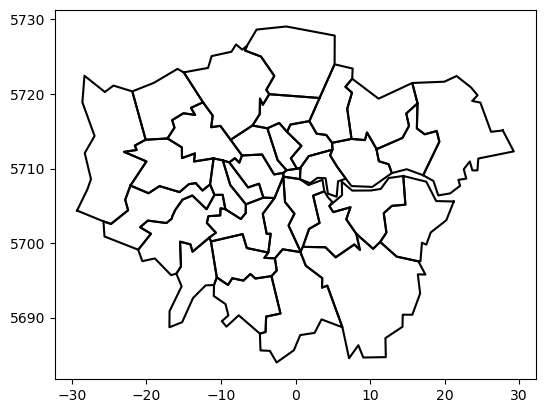

In [16]:
fig, ax = plt.subplots()
plot_polygons(ax, polygons_dst.values())
ax.set_aspect('equal')
ax.plot();

## Population Data

https://rasterio.readthedocs.io/en/latest/quickstart.html

https://hub.worldpop.org/geodata/listing?id=78

In [17]:
raster_filepath = os.path.join(data_dir, 'gbr_ppp_2020_constrained.tif') # population  / 3" where 1" is about 100m
#raster_filepath = 'data/gbr_pd_2020_1km_UNadj.tif' # density / 1km
dataset = rasterio.open(raster_filepath)

In [18]:
print(dataset.name)
print('No. of bands:', dataset.count)
print(f'height: {dataset.height} ; width: {dataset.width}')
print(dataset.bounds)
print('Upper left: ', dataset.transform * (0, 0))
print('Lower right:', dataset.transform * (dataset.width, dataset.height))
print('Co-ordinate reference system:', dataset.crs)
print(dataset.profile)

../../datasets/geospatial/gbr_ppp_2020_constrained.tif
No. of bands: 1
height: 13196 ; width: 12496
BoundingBox(left=-8.650416617, bottom=49.864583335, right=1.7629166749999996, top=60.861249958)
Upper left:  (-8.650416617, 60.861249958)
Lower right: (1.7629166749999996, 49.864583335)
Co-ordinate reference system: EPSG:4326
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 12496, 'height': 13196, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333300256081, 0.0, -8.650416617,
       0.0, -0.00083333333002425, 60.861249958), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [19]:
#img = dataset.read(1)

In [20]:
## Can be Very slow
# img[img<0] = 1
# img = np.log10(img+1)
# img[img==0] = np.nan

# fig, ax = plt.subplots()
# cax = ax.imshow(img)

## Clip to region of intersest

https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

In [21]:
boundaries = [Polygon(box(*region_polygon.bounds))]
with rasterio.open(raster_filepath) as src:
    img_region, transform_region = rasterio.mask.mask(src, boundaries, crop=True)
    img_region[img_region < 0] = 0

In [22]:
img = img_region[0, :, :]
print(img.max())
print(img.sum())

823.19714
10379211.0


In [23]:
# img_downscaled = block_reduce(img, block_size=4, func=np.sum)
# print(img.sum(), img_downscaled.sum(), img_downscaled.sum()/img.sum())

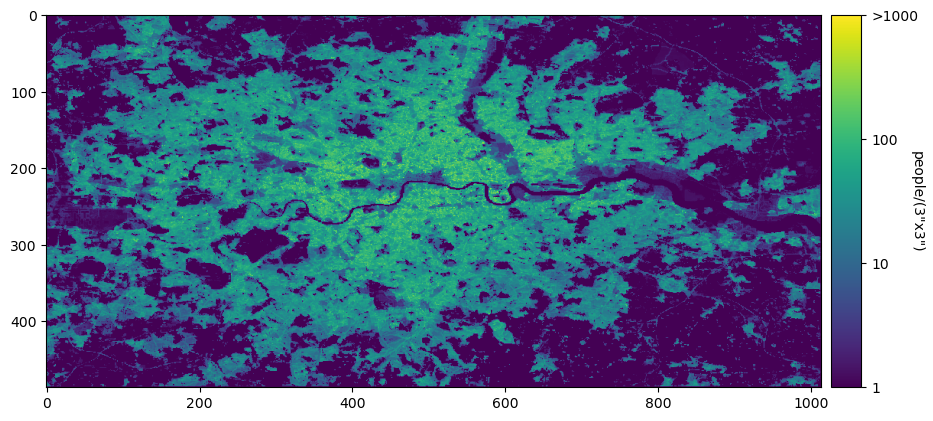

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
vmax = np.log10(1_000)

cmap = plt.get_cmap('viridis')#, 10)
axis_image = ax.imshow(np.log10(img + 1), vmax=vmax, cmap=cmap)
#fig.colorbar(axis_image)

cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar = fig.colorbar(axis_image, cbar_axis)
#cbar.set_label('people/km^2', rotation=270) # density
cbar.set_label('people/(3\"x3\")', rotation=270) # counts

ticks = np.log10([1, 10, 100, 1_000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

scales

In [25]:
height, width = img.shape
long_min, lat_min, long_max, lat_max = region_polygon.bounds
long_scale = 3600 * (lat_max - lat_min) / height
lat_scale = 3600 * (long_max - long_min) / width
print(f'{long_scale:.4f} arcseconds/pixel') 
print(f'{lat_scale:.4f} arcsecond/pixel') 
long_scale, lat_scale = get_scales(img.shape, region_polygon)
print(f'{long_scale:.2f} m/pixel') 
print(f'{lat_scale:.2f} m/pixel') 

2.9947 arcseconds/pixel
2.9954 arcsecond/pixel
92.50 m/pixel
57.61 m/pixel


units on axis

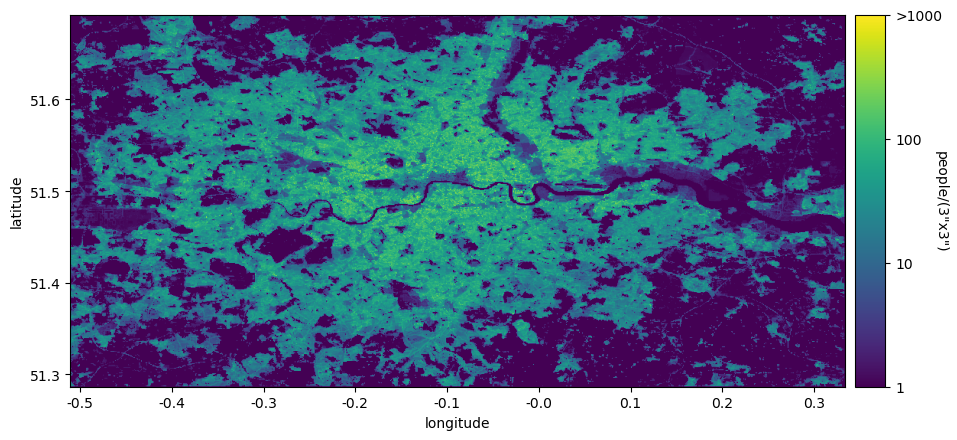

In [26]:
## long / lat
x_ticks, x_ticklabels = get_projection_xticks(transform_region, width, height)
y_ticks, y_ticklabels = get_projection_yticks(transform_region, width, height)
x_unit = 'longitude'
y_unit = 'latitude'

### km
# x_ticklabels = np.arange(0, lat_scale * width, 10_000)
# x_ticks = np.floor(x_ticklabels / lat_scale)
# x_ticklabels /= 1000
# y_ticklabels = np.arange(0, long_scale * height, 10_000)
# y_ticks = np.floor(y_ticklabels / long_scale)
# y_ticklabels /= 1000
# x_unit = 'km'
# y_unit = 'km'

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_xlabel(x_unit)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_ylabel(y_unit)
fig

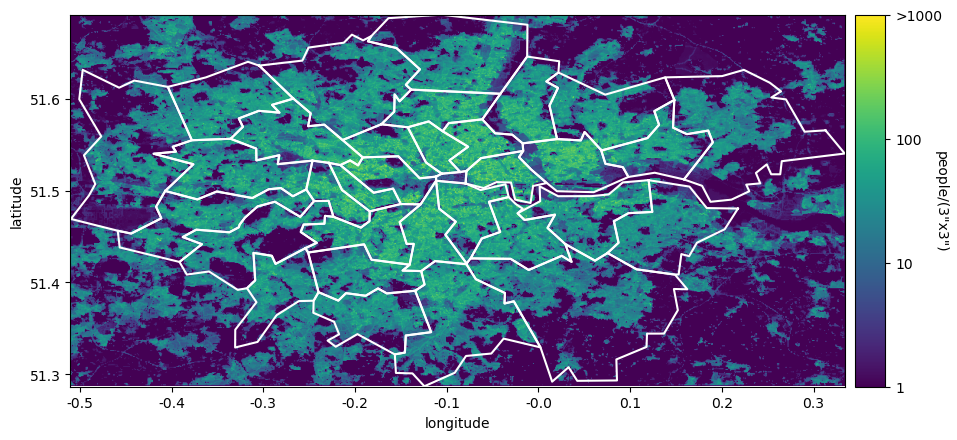

In [27]:
transform = transform_region
for polygon in admin_polygons.values(): 
    transformed_poly = [transform.__invert__() * coords for coords in polygon.exterior.coords]
    xs = [coords[0] for coords in transformed_poly] + [transformed_poly[0][0]]
    ys = [coords[1] for coords in transformed_poly] + [transformed_poly[0][1]]
    ax.plot(xs, ys, 'w-')
    #ax.fill_between(xs, ys, alpha=0.5, facecolor='black')
ax.set_xlim(left=0)
ax.set_xlim(right=width)
ax.set_ylim(bottom=height)
ax.set_ylim(top=0)
fig

Stats

In [28]:
show_stats(dataset, boundaries)

population: 10.38 million
max:        823 people / pixel
area:       2631.44 km^2
density:    3944.31 people/km^2


In [29]:
show_stats(dataset, admin_polygons.values())

population: 9.19 million
max:        823 people / pixel
area:       1577.36 km^2
density:    5824.56 people/km^2


### Reproject

Reproject onto a transverse mercator to remove distortion (longitude lines stretched apart)

- https://rasterio.readthedocs.io/en/latest/topics/reproject.html
- https://pygis.io/docs/d_raster_crs_intro.html
- http://pygis.io/docs/d_understand_crs_codes.html

In [30]:
height, width = img.shape
transform_dst, width_dst, height_dst = calculate_default_transform(
        dataset.crs, dst_crs, width, height, *region_polygon.bounds)
print((height_dst, width_dst))

(687, 896)


In [31]:
img_dst = np.zeros((height_dst, width_dst))
rasterio.warp.reproject(
    source=img_region[0, :, :],
    destination=img_dst,
    src_transform=transform_region,
    src_crs=dataset.crs,
    dst_transform=transform_dst,
    dst_crs=dst_crs,
    resampling=Resampling.bilinear
);

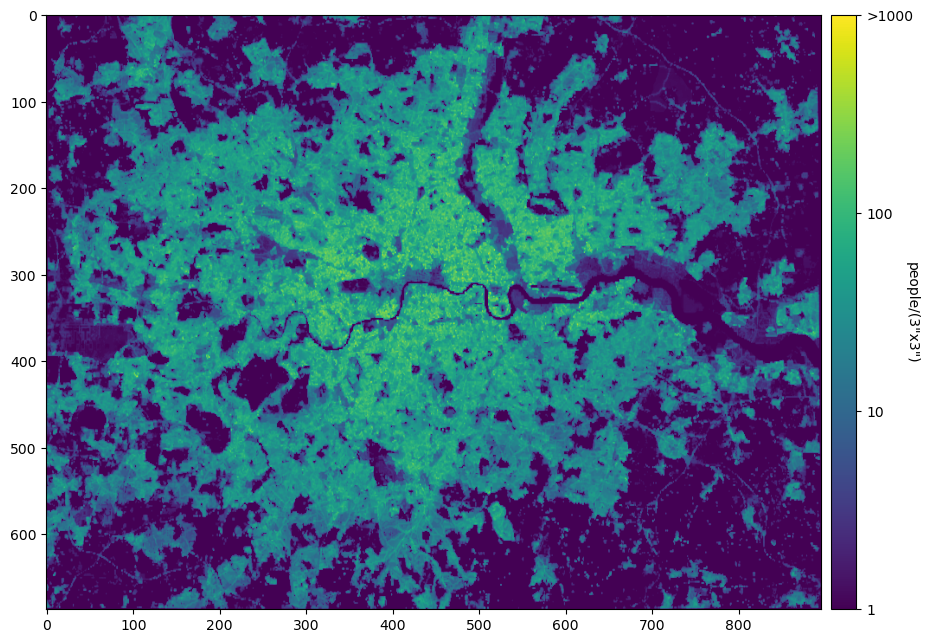

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
vmax = np.log10(1_000)

cmap = plt.get_cmap('viridis')#, 10)
axis_image = ax.imshow(np.log10(img_dst + 1), vmax=vmax, cmap=cmap)
#fig.colorbar(axis_image)

cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.025,ax.get_position().height])
cbar = fig.colorbar(axis_image, cbar_axis)
#cbar.set_label('people/km^2', rotation=270) # density
cbar.set_label('people/(3\"x3\")', rotation=270) # counts

ticks = np.log10([1, 10, 100, 1_000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

boundaries

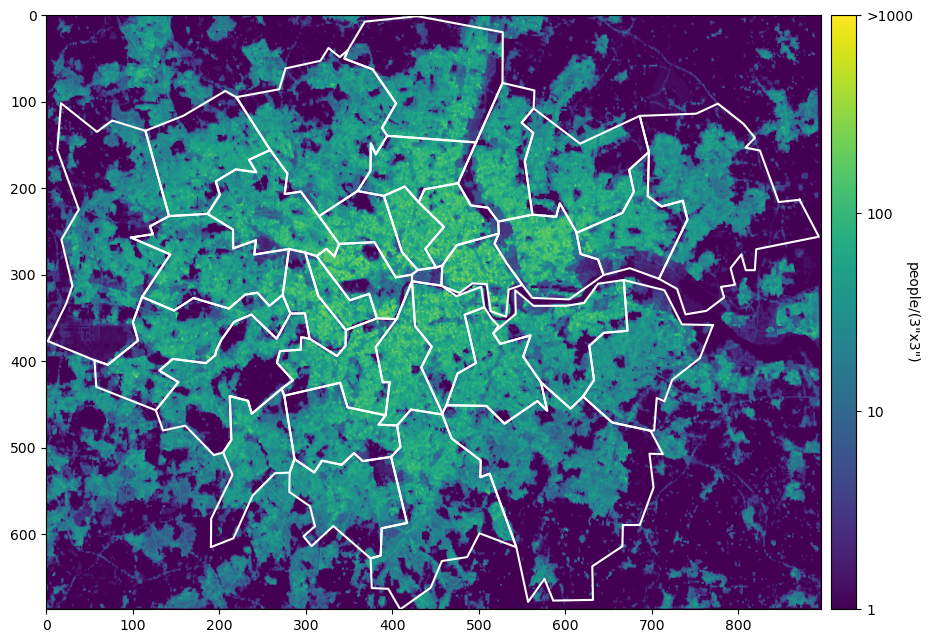

In [33]:
transform = transform_dst.__invert__()
for polygon in polygons_dst.values(): 
    polygon = [transform * coords for coords in polygon.exterior.coords]
    xs = [coords[0] for coords in polygon]
    ys = [coords[1] for coords in polygon]
    ax.plot(xs, ys, 'w-')
    #ax.fill_between(xs, ys, alpha=0.5, facecolor='black')
ax.set_xlim(left=0)
ax.set_xlim(right=width_dst)
ax.set_ylim(bottom=height_dst)
ax.set_ylim(top=0)
fig

units on axis

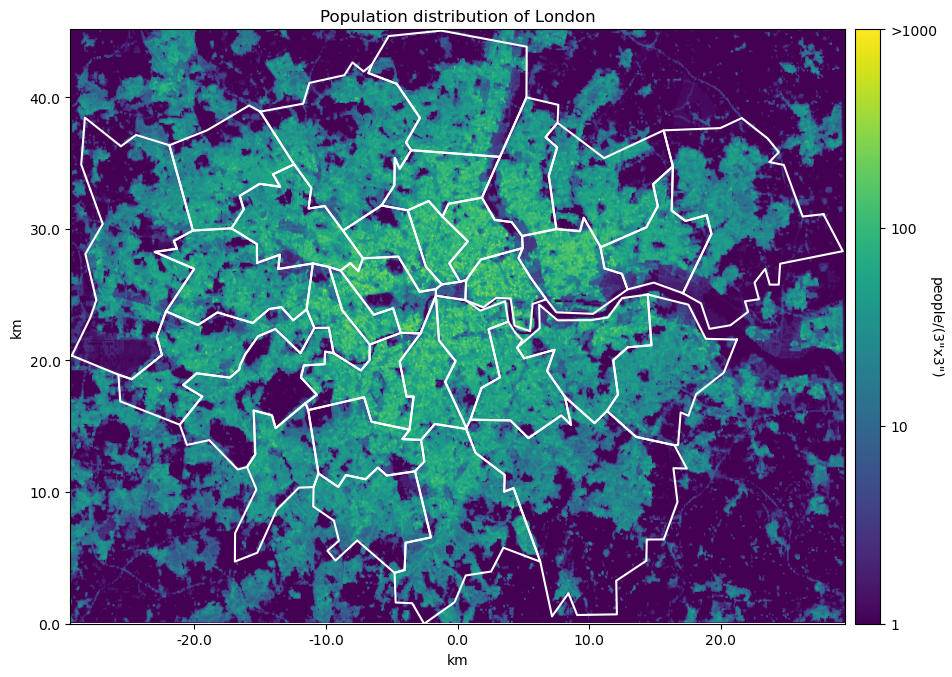

In [34]:
# distance from the central meridan. This always has a stretch factor stretch(long, lat).
# For a small region stretch=1 and so x_map=x_earth
x_ticks, x_ticklabels = get_projection_xticks(transform_dst, width_dst, height_dst, step_size=10)
# distance from the equator of the tranverse Mercator map. Only equivalent to earth distance at central meridan
# otherwise it is y_map * stretch(long) = y_earth
y_ticks, y_ticklabels = get_projection_yticks(transform_dst, width_dst, height_dst)
y_ticklabels -= y_ticklabels[0]

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_title(f'Population distribution of {region_name}')
fig

In [ ]:
fig.savefig('london_distribution.png', bbox_inches="tight")

## Compare to another city

In [35]:
other_polygons = new_york_polygons
other_name = 'New York'

In [36]:
print(region_polygon.bounds)
other_region = MultiPolygon(list(other_polygons.values()))
print(other_region.bounds)

(-0.509720585402481, 51.28676013985681, 0.333995664733011, 51.69187276890297)
(-74.26061251699997, 40.496111205000034, -73.70002135199996, 40.91758530000004)


In [37]:
other_raster_filepath = os.path.join(data_dir, 'usa_ppp_2020_constrained.tif') # population counts
with rasterio.open(other_raster_filepath) as src:
    other_img, transform_other = rasterio.mask.mask(src, other_polygons.values(), crop=True)
    other_img[other_img < 0] = 0
    print(f'----- {other_name} -----')
    show_stats(src, other_polygons.values())

#boundary = box(27.1, -25.8, 28.6, -26.6) # Joburg, South Africa
boundary = box(-1.2, 51.25, 0.33, 51.75) # London
with rasterio.open(raster_filepath) as src:
    base_image, transform_base = rasterio.mask.mask(src, [boundary], crop=True)
    base_image[base_image < 0] = 0
    print(f'----- {region_name} Region -----')
    show_stats(src, [boundary])
    print(f'----- {region_name} -----')
    show_stats(src, admin_polygons.values())

----- New York -----
population: 8.33 million
max:        2677 people / pixel
area:       922.16 km^2
density:    9036.84 people/km^2
----- London Region -----
population: 12.61 million
max:        823 people / pixel
area:       5888.17 km^2
density:    2141.84 people/km^2
----- London -----
population: 9.19 million
max:        823 people / pixel
area:       1577.36 km^2
density:    5824.56 people/km^2


reproject so that distortion for both is minimised

In [38]:
base_crs = deepcopy(dst_crs)
other_long_min, other_lat_min, other_long_max, other_lat_max = other_region.bounds
other_long_avg = (other_long_min + other_long_max) / 2
other_crs = deepcopy(base_crs)
other_crs['lon_0'] = other_long_avg
src_crs = dataset.crs

In [39]:
height_base, width_base = base_image.shape[1:3]
transform_base_dst, width_base_dst, height_base_dst = calculate_default_transform(
        src_crs, base_crs, width_base, height_base, *boundary.bounds)
print((height_base, width_base))
print((height_base_dst, width_base_dst))

(601, 1837)
(906, 1722)


In [40]:
height_other, width_other = other_img.shape[1:3]
transform_other_dst, width_other_dst, height_other_dst = calculate_default_transform(
        src_crs, other_crs, width_other, height_other, *other_region.bounds)
print((height_other, width_other))
print((height_other_dst, width_other_dst))

(507, 674)
(593, 602)


set other scale the same as base transform

In [41]:
scale_old = transform_other_dst.a
a = transform_base_dst.a
b = transform_base_dst.b
c = transform_other_dst.c
d = transform_base_dst.d
e = transform_base_dst.e
f = transform_other_dst.f
transform_other_dst = Affine(a, b, c, d, e, f)
# scale = (east - west) / width
# scale_ratio = [(east - west) / old_width] / [(east - west) / new_width] = new_width / old_width
scale_ratio = scale_old / transform_base_dst.a 
print(scale_ratio)
height_other_dst = np.round(height_other_dst * scale_ratio).astype(int)
width_other_dst = np.round(width_other_dst * scale_ratio).astype(int)
print((height_other_dst, width_other_dst))

1.2725816142809048
(755, 766)


In [42]:
base_img_dst = np.zeros((height_base_dst, width_base_dst))
rasterio.warp.reproject(
    source=base_image[0, :, :],
    destination=base_img_dst,
    src_transform=transform_base,
    src_crs=src_crs,
    dst_transform=transform_base_dst,
    dst_crs=base_crs,
    resampling=Resampling.bilinear
);

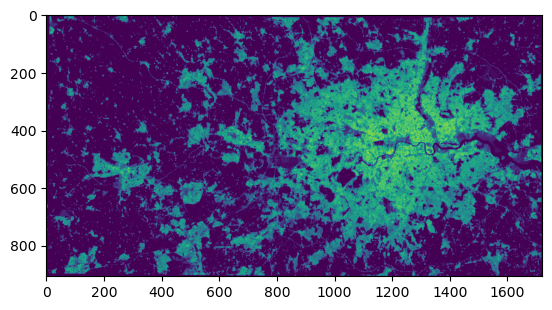

In [43]:
#plt.imshow(np.log10(base_image[0, :, :] + 1))
plt.imshow(np.log10(base_img_dst + 1));

In [44]:
other_img_dst = np.zeros((height_other_dst, width_other_dst))
rasterio.warp.reproject(
    source=other_img[0, :, :],
    destination=other_img_dst,
    src_transform=transform_other,
    src_crs=src_crs,
    dst_transform=Affine(a, b, c, d, e, f),
    dst_crs=other_crs,
    resampling=Resampling.bilinear
);

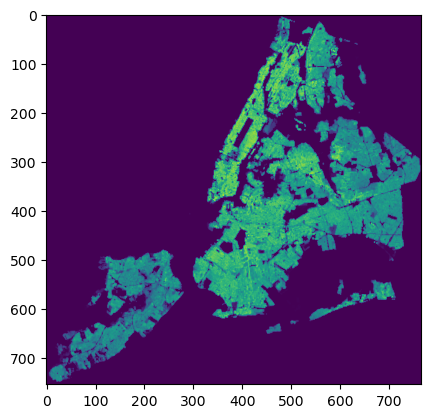

In [45]:
plt.imshow(np.log10(other_img_dst + 1));

insert other image in base image

In [46]:
origin_other = (0, np.floor((height_base_dst - height_other_dst)/ 2).astype(int)) # far left, middle
origin_other

(0, 75)

In [47]:
img_combined = base_img_dst.copy()
j_o, i_o = origin_other
i_n, j_n = other_img_dst.shape
img_combined[i_o:(i_o + i_n), j_o:(j_o + j_n)] = other_img_dst          

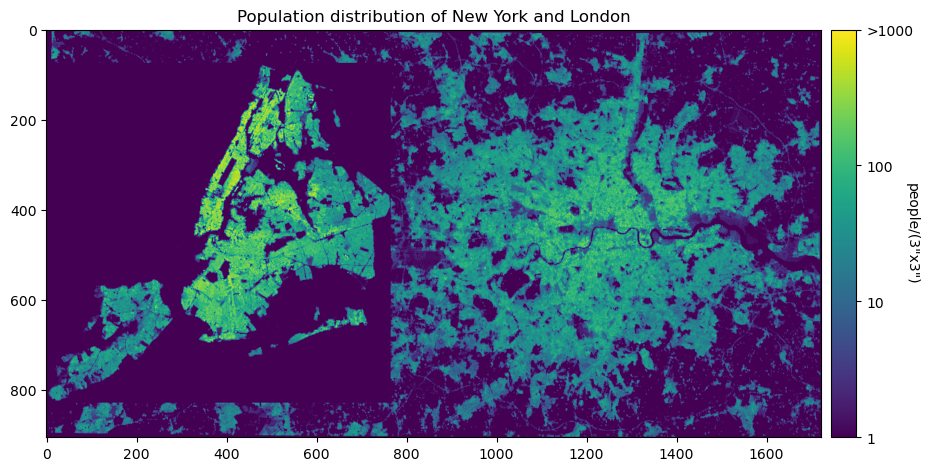

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title(f'Population distribution of {other_name} and {region_name}')
vmax = np.log10(1_000)
cmap = plt.get_cmap('viridis') #, 10)
img_axis = ax.imshow(np.log10(img_combined + 1), vmax=vmax, cmap=cmap)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.025,ax.get_position().height])
cbar = fig.colorbar(img_axis, cax)
#cbar.set_label('people/km^2', rotation=270) # density
cbar.set_label('people/(3\"x3\")', rotation=270) 
ticks = np.log10([1, 10, 100, 1000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

Boundaries

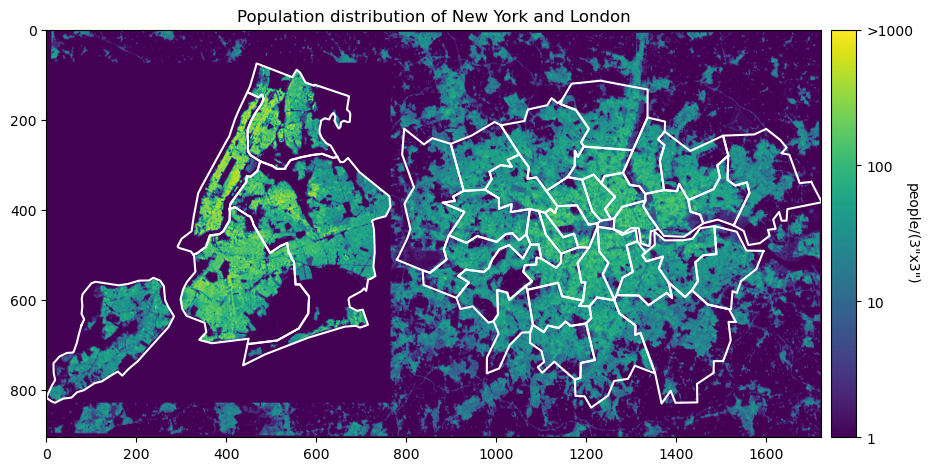

In [49]:
transform_inverse = transform_base_dst.__invert__()
polygons_dst = transform_geom(
    src_crs,
    base_crs,
    admin_polygons.values()
)
for geom in polygons_dst: 
    polygon = [transform_inverse * coords for coords in geom['coordinates'][0]]
    xs = [coords[0] for coords in polygon]
    ys = [coords[1] for coords in polygon]
    ax.plot(xs, ys, 'w-')

long_min, lat_min, long_max, lat_max = boundary.bounds
xoff = -other_long_min + long_min
yoff = -other_lat_max + lat_max
polygons_dst = transform_geom(
    src_crs,
    other_crs,
    other_polygons.values()
)
transform_inverse = transform_other_dst.__invert__()
for geom in polygons_dst: 
    polygon = np.array([transform_inverse * (x, y) for x, y in geom['coordinates'][0]])
    polygon += origin_other
    xs = [coords[0] for coords in polygon]
    ys = [coords[1] for coords in polygon]
    ax.plot(xs, ys, 'w-')
    
height, width = img_combined.shape
ax.set_xlim(left=0)
ax.set_xlim(right=width)
ax.set_ylim(bottom=height)
ax.set_ylim(top=0)
fig

Set axis units

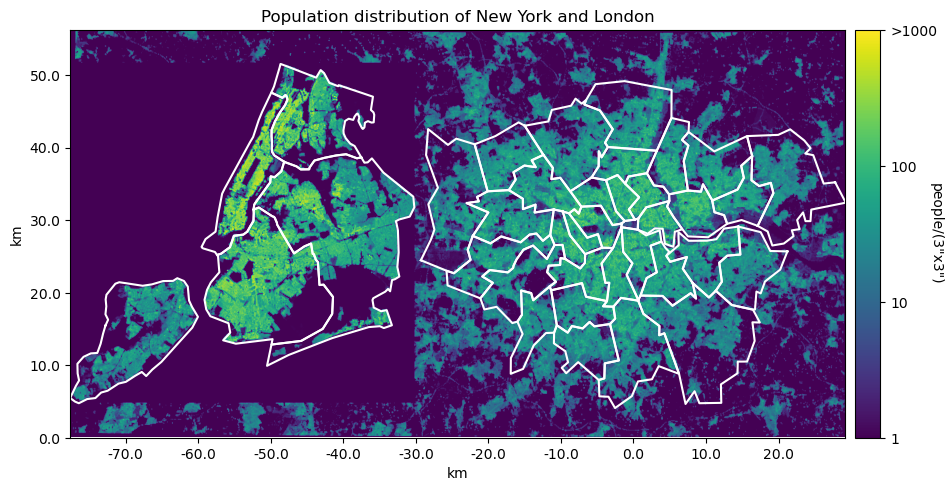

In [50]:
# distance from the central meridan. This always has a stretch factor stretch(long, lat).
# For a small region stretch=1 and so x_map=x_earth
x_ticks, x_ticklabels = get_projection_xticks(transform_base_dst, width_base_dst, height_base_dst, 10)
# distance from the equator of the tranverse Mercator map. Only equivalent to earth distance at central meridan
# otherwise it is y_map * stretch(long) = y_earth
y_ticks, y_ticklabels = get_projection_yticks(transform_base_dst, width_base_dst, height_base_dst)
y_ticklabels -= y_ticklabels[0]

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_xlabel('km')
ax.set_ylabel('km')
fig

admin boundaries

In [ ]:
fig.savefig('london_ny_distribution.png', bbox_inches="tight")